In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
from PIL import Image
import urllib

In [31]:
chromedriver_autoinstaller.install()
import warnings
warnings.filterwarnings('ignore')

## Pull Data

In [32]:
if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640737/Live/England-Premier-League-2022-2023-Fulham-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640737


## Colours 

In [33]:
home_color = '#9C9C9C'
away_color = '#2D5DE7'

## Filter data to get passes
- Whoscored doesn't have pass recipient - so need to add automatically
- Just shift index by one
- Also have instances where pass is successful but recipient is to another team (half end/free kicks?) - so make sure team id or recipient and player is the same

In [34]:
events_df["passRecipient"] = events_df['playerName'].shift(-1)
events_df['teamRecipient'] = events_df['teamId'].shift(-1)
column_to_move = events_df.pop("passRecipient")
events_df.insert(26, "passRecipient", column_to_move)
column_to_move = events_df.pop("teamRecipient")
events_df.insert(27, "teamRecipient", column_to_move)

In [35]:
events_df__ = events_df.copy()

In [36]:
events_df2 = events_df[(events_df['type'] == 'Pass')]

In [37]:
events_df = events_df[(events_df['type'] == 'Pass') & (events_df['outcomeType'] == 'Successful')]
#                       & (events_df['teamId'] == events_df['teamRecipient']) ]

## Passes between 2 players

In [38]:
passes_df = events_df[['eventId','playerName', 'passRecipient']]
passes_df = passes_df.dropna()

In [39]:
passes_df['pair'] = passes_df['playerName'] + ' ' + passes_df['passRecipient']
passes_df

eventId          playerName       passRecipient  \
2           4       Harrison Reed    Tosin Adarabioyo   
3           5    Tosin Adarabioyo             Willian   
5           4   César Azpilicueta     Trevoh Chalobah   
8           9             Willian    Antonee Robinson   
11          7   Kepa Arrizabalaga   Kalidou Koulibaly   
...       ...                 ...                 ...   
1640      909      Marc Cucurella     Conor Gallagher   
1641      910     Conor Gallagher        Thiago Silva   
1642      911        Thiago Silva      Marc Cucurella   
1643      912      Marc Cucurella  Carney Chukwuemeka   
1644      913  Carney Chukwuemeka      Marc Cucurella   

                                     pair  
2          Harrison Reed Tosin Adarabioyo  
3                Tosin Adarabioyo Willian  
5       César Azpilicueta Trevoh Chalobah  
8                Willian Antonee Robinson  
11    Kepa Arrizabalaga Kalidou Koulibaly  
...                                   ...  
1640       Marc Cucurella Conor Gallagher  
1641         Conor Gallagher Thiago Silva  
1642          Thiago Silva Marc Cucurella  
1643    Marc Cucurella Carney Chukwuemeka  
1644    Carney Chukwuemeka Marc Cucurella  

[826 rows x 4 columns]

In [40]:
passes_count = passes_df.groupby(['pair']).count().reset_index()
passes_count = passes_count[['pair', 'eventId']]
passes_count.columns = ['pair', 'passes']
passes_count

pair  passes
0         Andreas Pereira Antonee Robinson       2
1    Andreas Pereira Bobby De Cordova-Reid       3
2          Andreas Pereira Carlos Vinícius       1
3            Andreas Pereira Harrison Reed       2
4             Andreas Pereira Harry Wilson       8
..                                     ...     ...
256                  Willian João Palhinha       1
257                     Willian Kenny Tete       2
258                       Willian Tim Ream       1
259                    Willian Tom Cairney       7
260               Willian Tosin Adarabioyo       2

[261 rows x 2 columns]

## Average position for each player

In [41]:
avg_loc_df = events_df__[['teamId', 'playerName', 'x', 'y']]
avg_loc_df = avg_loc_df.groupby(['teamId', 'playerName']).agg({'x':np.mean, 'y':[np.mean, 'count']}).reset_index()
avg_loc_df.columns = ['teamId', 'playerName', 'x','y', 'count']
avg_loc_df

teamId             playerName          x          y  count
0       15     Carney Chukwuemeka  49.595000  66.590000     20
1       15        Conor Gallagher  31.893333  43.833333     15
2       15      César Azpilicueta  39.985714  15.703175     63
3       15          Denis Zakaria  40.253659  54.019512     41
4       15           Hakim Ziyech  57.820000  55.990000     10
5       15               Jorginho  38.094000  49.508000     50
6       15             João Félix  57.706383  58.976596     47
7       15            Kai Havertz  59.081818  58.462121     66
8       15      Kalidou Koulibaly  32.757143  72.141905    105
9       15      Kepa Arrizabalaga  10.511628  50.348837     43
10      15             Lewis Hall  35.928049  82.132927     82
11      15         Marc Cucurella  53.000000  86.770370     27
12      15            Mason Mount  59.758065  36.835484     62
13      15          Mateo Kovacic  50.344595  68.636486     74
14      15           Thiago Silva  31.647143  44.670000     70
15      15        Trevoh Chalobah  33.959722  22.291667     72
16     170        Andreas Pereira  62.493846  49.026154     65
17     170       Antonee Robinson  46.540698  86.870930     86
18     170             Bernd Leno   8.238182  46.090909     55
19     170  Bobby De Cordova-Reid  68.509524  16.783333     42
20     170        Carlos Vinícius  63.607500  61.687500     40
21     170              Dan James  62.933333  10.366667      3
22     170          Harrison Reed  56.060465  31.200000     43
23     170           Harry Wilson  65.412000  12.928000     25
24     170          João Palhinha  47.198529  49.933824     68
25     170             Kenny Tete  49.215957  13.307447     94
26     170          Manor Solomon  61.277778  82.000000      9
27     170     Nathaniel Chalobah  42.440000  16.400000      5
28     170               Tim Ream  33.028378  66.827027     74
29     170            Tom Cairney  60.905882  63.302941     34
30     170       Tosin Adarabioyo  32.890323  35.956989     93
31     170                Willian  60.607407  77.627778     54

## Merge Data  

In [42]:
passes_merge = passes_df.merge(passes_count, on='pair')
passes_merge = passes_merge[['playerName', 'passRecipient', 'passes']]
passes_merge = passes_merge.drop_duplicates().reset_index(drop=True)
passes_merge

playerName       passRecipient  passes
0         Harrison Reed    Tosin Adarabioyo       2
1      Tosin Adarabioyo             Willian       2
2     César Azpilicueta     Trevoh Chalobah       7
3               Willian    Antonee Robinson       9
4     Kepa Arrizabalaga   Kalidou Koulibaly      11
..                  ...                 ...     ...
256         Kai Havertz     Conor Gallagher       1
257     Conor Gallagher  Carney Chukwuemeka       1
258        Harry Wilson  Nathaniel Chalobah       1
259  Nathaniel Chalobah         Tom Cairney       1
260      Marc Cucurella     Conor Gallagher       1

[261 rows x 3 columns]

In [43]:
avg_loc_df = avg_loc_df[['playerName', 'x', 'y', 'count']]
pass_map = passes_merge.merge(avg_loc_df, on='playerName')
pass_map.rename({'x':'x_start', 'y':'y_start'}, axis='columns', inplace=True)
pass_map = pass_map.merge(avg_loc_df, left_on = 'passRecipient', right_on='playerName', suffixes = ['', '_end'])
pass_map.rename({'x':'x_end', 'y':'y_end'}, axis='columns', inplace=True)
pass_map = pass_map.drop(['playerName_end', 'count_end'], axis=1)
pass_map = pass_map[pass_map['playerName'] != pass_map['passRecipient']]
pass_map

playerName       passRecipient  passes    x_start    y_start  \
0       Harrison Reed    Tosin Adarabioyo       2  56.060465  31.200000   
2             Willian    Tosin Adarabioyo       2  60.607407  77.627778   
3          Lewis Hall    Tosin Adarabioyo       1  35.928049  82.132927   
4    Antonee Robinson    Tosin Adarabioyo       3  46.540698  86.870930   
5          Kenny Tete    Tosin Adarabioyo       8  49.215957  13.307447   
..                ...                 ...     ...        ...        ...   
256        Kenny Tete  Nathaniel Chalobah       1  49.215957  13.307447   
257          Tim Ream  Nathaniel Chalobah       1  33.028378  66.827027   
258      Harry Wilson  Nathaniel Chalobah       1  65.412000  12.928000   
259        Kenny Tete           Dan James       1  49.215957  13.307447   
260      Harry Wilson           Dan James       1  65.412000  12.928000   

     count      x_end      y_end  
0       43  32.890323  35.956989  
2       54  32.890323  35.956989  
3       82  32.890323  35.956989  
4       86  32.890323  35.956989  
5       94  32.890323  35.956989  
..     ...        ...        ...  
256     94  42.440000  16.400000  
257     74  42.440000  16.400000  
258     25  42.440000  16.400000  
259     94  62.933333  10.366667  
260     25  62.933333  10.366667  

[260 rows x 8 columns]

## Keep T1 Players

In [44]:
id1 = home_data['teamId']
id2 = away_data['teamId']

In [45]:
team1_players = events_df__[events_df__.teamId == id1].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team1_players = pd.concat([team1_players['playerName'], team1_players['minute']], axis=1)
team1_players['mins_played'] = team1_players['max'] - team1_players['min']
team1_players = team1_players.sort_values('mins_played', ascending=False)
team1_players_names = team1_players.playerName
passes_t1 = pass_map[(pass_map['playerName'].isin(team1_players_names)) & 
                     (pass_map['passRecipient'].isin(team1_players_names))]
team1_players_names_top11 = team1_players.playerName[:11].tolist()
team1_players_names_top11
team1_players_names_top11


['Tosin Adarabioyo',
 'Bernd Leno',
 'Tim Ream',
 'Antonee Robinson',
 'Carlos Vinícius',
 'Kenny Tete',
 'Andreas Pereira',
 'João Palhinha',
 'Willian',
 'Harrison Reed',
 'Bobby De Cordova-Reid']

## Top 3 players with most completed passes

In [46]:
comp_passes = passes_t1.groupby('playerName')[['playerName','passes']].sum().reset_index().sort_values(by='passes',
                                                                                        ascending=False)
comp_passes = comp_passes[:3]
# comp_passes = comp_passes[comp_passes['playerName'].isin(team1_players_names_top11)][:3]
team1_players_names_top11
comp_passes_list = []
for p, passes in zip(comp_passes['playerName'], comp_passes['passes']):
    comp_passes_list.append([p, passes])
comp_passes_list

[['Kenny Tete', 52], ['Tosin Adarabioyo', 51], ['Tim Ream', 47]]

## Top 3 Combinations

In [47]:
combos = passes_t1.sort_values(by='passes', ascending=False)
# combos = combos[(combos['playerName'].isin(team1_players_names_top11)) & (combos['passRecipient'].isin(team1_players_names_top11))]
combos = combos[:3][['playerName', 'passRecipient', 'passes']]
combos_list = []
for p1, p2, cnt in zip(combos['playerName'], combos['passRecipient'], combos['passes']):
    combos_list.append([p1,p2, cnt])
combos_list

[['Tosin Adarabioyo', 'Kenny Tete', 16],
 ['Bernd Leno', 'Tim Ream', 15],
 ['Tim Ream', 'Antonee Robinson', 15]]

## Prog. Pass Field + Top 3 Prog. Passes

In [48]:
prog_passes = events_df[events_df['teamId'] == id1][['playerName', 'passRecipient', 'type', 'x', 'y', 'endX', 'endY']]
prog_passes.rename({'x':'x_start', 'y':'y_start', 'endX': 'x_end', 'endY':'y_end'}, axis='columns', inplace=True)
# prog_passes = prog_passes[(prog_passes['playerName'].isin(team1_players_names))]
prog_passes = prog_passes.reset_index(drop=True)

prog_passes['Progressive'] = ''
for i in range(len(prog_passes)):
    x_0 = 120*(prog_passes['x_start'][i])/100
    y_0 = 80*(prog_passes['y_start'][i])/100
    x_1 = 120*(prog_passes['x_end'][i])/100
    y_1 = 80*(prog_passes['y_end'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        prog_passes['Progressive'][i] = 'True'
    else:
        prog_passes['Progressive'][i] = 'False'

        
prog_passes2 = prog_passes[prog_passes['Progressive'] == 'True'].groupby('playerName')['type'].count().sort_values(ascending=False).reset_index()
prog_passes2 = prog_passes2[:3]
# prog_passes2 = prog_passes2[prog_passes2['playerName'].isin(team1_players_names_top11)][:3]
prog_passes_list = []
for p, cnt in zip(prog_passes2['playerName'], prog_passes2['type']):
    prog_passes_list.append([p,cnt])

prog_received = pd.DataFrame(prog_passes[prog_passes['Progressive'] == 'True'].groupby('passRecipient')['type'].count().sort_values(ascending=False)).reset_index()
prog_received = prog_received[:3]
# prog_received = prog_received[prog_received['passRecipient'].isin(team1_players_names_top11)][:3]
prog_received_list = []
for p, cnt in zip(prog_received['passRecipient'], prog_received['type']):
    prog_received_list.append([p,cnt])

prog_received_list

[['Carlos Vinícius', 14], ['Bobby De Cordova-Reid', 9], ['Andreas Pereira', 4]]

## Top 3 Pass Completion

In [49]:
events_df3 = events_df2[events_df2['playerName'].isin(team1_players_names_top11)][['playerName','outcomeType']]
pass_comp_df = pd.DataFrame(events_df3.groupby(['playerName', 'outcomeType']).size()).unstack(fill_value=0).stack().reset_index()
pass_comp_df.columns = ['playerName', 'outcome', 'count']
pass_comp = []
for i in range(0, len(pass_comp_df), 2):
    rate = pass_comp_df['count'][i] / (pass_comp_df['count'][i]+pass_comp_df['count'][i+1])
    pass_comp.append([pass_comp_df['playerName'][i], rate])

pass_comp.sort(key=lambda x:x[1], reverse=True)
pass_comp = pass_comp[0:3]
for i, val in enumerate(pass_comp):
    val[1] = round(float(val[1])*100)
pass_comp
    

[['Tim Ream', 87], ['Tosin Adarabioyo', 87], ['João Palhinha', 83]]

## Top 3 xThreat via Pass

In [50]:
df_passes = events_df__[(events_df__['type'] == 'Pass') & (events_df__['outcomeType'] == 'Successful') & 
                        (events_df__['teamId'] == id1)].reset_index(drop=True)

xT_list = []
path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xT = pd.read_json(path)
xT = np.array(xT).T
xT_rows, xT_cols = xT.shape

x_bins = np.array(np.linspace(0,100, 13), dtype=object)
y_bins = np.array(np.linspace(0, 100, 9), dtype=object)

for name in team1_players_names_top11:
    test = df_passes[(df_passes['playerName'] == name) &
                     (df_passes['passFreekick'] == False) & 
                     (df_passes['passCorner'] == False) &
                     (df_passes['throwIn'] == False)]
    
    if len(test) > 0:
        test['x1_bin'] = pd.cut(test['x'], bins=x_bins, labels=False, include_lowest=True)
        test['x2_bin'] = pd.cut(test['endX'], bins=x_bins, labels=False, include_lowest=True)
        test['y1_bin'] = pd.cut(test['y'], bins=y_bins, labels=False, include_lowest=True)
        test['y2_bin'] = pd.cut(test['endY'], bins=y_bins, labels=False, include_lowest=True)
        test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
        test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
        test['xT_diff'] = test['xT_end'] - test['xT_start']
        test = test[test['xT_diff']>0].reset_index(drop=True)
        xT_added = test['xT_diff'].sum()
    
    xT_list.append([name, xT_added])
    
xT_list.sort(key=lambda x:x[1], reverse=True)
xT_list2 = xT_list.copy()
xT_list = xT_list[:3]
for i, val in enumerate(xT_list):
    val[1] = round(float(val[1]),2)
xT_list

[['Andreas Pereira', 0.39], ['Kenny Tete', 0.39], ['Antonee Robinson', 0.15]]

In [51]:
xT_scaled = []
minXT = abs(min(xT_list2, key=lambda x:x[1])[1])
for player, xT in xT_list2:
    xT_updated = xT + minXT + 0.05
    xT_scaled.append([player, xT_updated])
df_xT = pd.DataFrame(xT_scaled, columns=['playerName', 'xThreat'])
df_xT

playerName   xThreat
0         Andreas Pereira  0.447772
1              Kenny Tete  0.447772
2        Antonee Robinson  0.207772
3                 Willian  0.166415
4        Tosin Adarabioyo  0.150607
5                Tim Ream  0.128276
6           João Palhinha  0.103966
7         Carlos Vinícius  0.095174
8   Bobby De Cordova-Reid  0.078587
9           Harrison Reed  0.075632
10             Bernd Leno  0.065545

## Keep 11 players with most mins

In [52]:
# Get line width and just count instances of 4/more passes
team1_players_names = team1_players.playerName[:11].tolist()
passes_t1 = pass_map[(pass_map['playerName'].isin(team1_players_names)) & 
                     (pass_map['passRecipient'].isin(team1_players_names))]
passes_t1['width'] = passes_t1['passes']/passes_t1['passes'].max() * 10
passes_t1

playerName     passRecipient  passes    x_start    y_start  count  \
0       Harrison Reed  Tosin Adarabioyo       2  56.060465  31.200000     43   
2             Willian  Tosin Adarabioyo       2  60.607407  77.627778     54   
4    Antonee Robinson  Tosin Adarabioyo       3  46.540698  86.870930     86   
5          Kenny Tete  Tosin Adarabioyo       8  49.215957  13.307447     94   
6            Tim Ream  Tosin Adarabioyo       9  33.028378  66.827027     74   
..                ...               ...     ...        ...        ...    ...   
100           Willian   Carlos Vinícius       4  60.607407  77.627778     54   
101  Antonee Robinson   Carlos Vinícius       7  46.540698  86.870930     86   
102        Kenny Tete   Carlos Vinícius       6  49.215957  13.307447     94   
103   Andreas Pereira   Carlos Vinícius       1  62.493846  49.026154     65   
104     João Palhinha   Carlos Vinícius       1  47.198529  49.933824     68   

         x_end      y_end  width  
0    32.890323  35.956989  1.250  
2    32.890323  35.956989  1.250  
4    32.890323  35.956989  1.875  
5    32.890323  35.956989  5.000  
6    32.890323  35.956989  5.625  
..         ...        ...    ...  
100  63.607500  61.687500  2.500  
101  63.607500  61.687500  4.375  
102  63.607500  61.687500  3.750  
103  63.607500  61.687500  0.625  
104  63.607500  61.687500  0.625  

[81 rows x 9 columns]

In [53]:
# Set marker size and keep over 4 passes
# passes_t1 = passes_t1[passes_t1['passes']>=2]
passes_t1['passes'][passes_t1['passes']<=3] = 0
passes_t1['marker_size'] = (passes_t1['count']
                                         / passes_t1['count'].max() * 2000)
passes_t1.groupby('playerName')['count'].mean()

playerName
Andreas Pereira          65.0
Antonee Robinson         86.0
Bernd Leno               55.0
Bobby De Cordova-Reid    42.0
Carlos Vinícius          40.0
Harrison Reed            43.0
João Palhinha            68.0
Kenny Tete               94.0
Tim Ream                 74.0
Tosin Adarabioyo         93.0
Willian                  54.0
Name: count, dtype: float64

In [54]:
passes_t1 = passes_t1.merge(df_xT, on='playerName')
passes_t1

playerName          passRecipient  passes    x_start  y_start  count  \
0     Harrison Reed       Tosin Adarabioyo       0  56.060465  31.2000     43   
1     Harrison Reed             Kenny Tete       5  56.060465  31.2000     43   
2     Harrison Reed       Antonee Robinson       0  56.060465  31.2000     43   
3     Harrison Reed          João Palhinha       0  56.060465  31.2000     43   
4     Harrison Reed        Andreas Pereira       0  56.060465  31.2000     43   
..              ...                    ...     ...        ...      ...    ...   
76  Carlos Vinícius       Antonee Robinson       0  63.607500  61.6875     40   
77  Carlos Vinícius          João Palhinha       0  63.607500  61.6875     40   
78  Carlos Vinícius  Bobby De Cordova-Reid       0  63.607500  61.6875     40   
79  Carlos Vinícius                Willian       0  63.607500  61.6875     40   
80  Carlos Vinícius          Harrison Reed       0  63.607500  61.6875     40   

        x_end      y_end  width  marker_size   xThreat  
0   32.890323  35.956989  1.250   914.893617  0.075632  
1   49.215957  13.307447  3.125   914.893617  0.075632  
2   46.540698  86.870930  1.250   914.893617  0.075632  
3   47.198529  49.933824  0.625   914.893617  0.075632  
4   62.493846  49.026154  1.250   914.893617  0.075632  
..        ...        ...    ...          ...       ...  
76  46.540698  86.870930  0.625   851.063830  0.095174  
77  47.198529  49.933824  1.250   851.063830  0.095174  
78  68.509524  16.783333  0.625   851.063830  0.095174  
79  60.607407  77.627778  0.625   851.063830  0.095174  
80  56.060465  31.200000  0.625   851.063830  0.095174  

[81 rows x 11 columns]

## Get Shirt Numbers and merge to passes df 

In [55]:
shirt_nos = matches_df['home'][matchId]['formations'][0]['jerseyNumbers']
playerIds = matches_df['home'][matchId]['formations'][0]['playerIds']
shirt_nos = pd.DataFrame({'no':shirt_nos, 'playerId':playerIds})
playerIds = events_df[['playerId', 'playerName']]
passes_t1 = passes_t1.merge(playerIds, on='playerName')
shirt_nos['playerId'] = shirt_nos['playerId'].astype(str)
passes_t1 = passes_t1.merge(shirt_nos, on='playerId')
passes_t1 = passes_t1.drop_duplicates().reset_index(drop=True)
passes_t1

playerName          passRecipient  passes    x_start  y_start  count  \
0     Harrison Reed       Tosin Adarabioyo       0  56.060465  31.2000     43   
1     Harrison Reed             Kenny Tete       5  56.060465  31.2000     43   
2     Harrison Reed       Antonee Robinson       0  56.060465  31.2000     43   
3     Harrison Reed          João Palhinha       0  56.060465  31.2000     43   
4     Harrison Reed        Andreas Pereira       0  56.060465  31.2000     43   
..              ...                    ...     ...        ...      ...    ...   
76  Carlos Vinícius       Antonee Robinson       0  63.607500  61.6875     40   
77  Carlos Vinícius          João Palhinha       0  63.607500  61.6875     40   
78  Carlos Vinícius  Bobby De Cordova-Reid       0  63.607500  61.6875     40   
79  Carlos Vinícius                Willian       0  63.607500  61.6875     40   
80  Carlos Vinícius          Harrison Reed       0  63.607500  61.6875     40   

        x_end      y_end  width  marker_size   xThreat playerId  no  
0   32.890323  35.956989  1.250   914.893617  0.075632   135724   6  
1   49.215957  13.307447  3.125   914.893617  0.075632   135724   6  
2   46.540698  86.870930  1.250   914.893617  0.075632   135724   6  
3   47.198529  49.933824  0.625   914.893617  0.075632   135724   6  
4   62.493846  49.026154  1.250   914.893617  0.075632   135724   6  
..        ...        ...    ...          ...       ...      ...  ..  
76  46.540698  86.870930  0.625   851.063830  0.095174   363077  30  
77  47.198529  49.933824  1.250   851.063830  0.095174   363077  30  
78  68.509524  16.783333  0.625   851.063830  0.095174   363077  30  
79  60.607407  77.627778  0.625   851.063830  0.095174   363077  30  
80  56.060465  31.200000  0.625   851.063830  0.095174   363077  30  

[81 rows x 13 columns]

## Repeat above for away team 

In [56]:
team2_players = events_df__[events_df__.teamId == id2].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team2_players = pd.concat([team2_players['playerName'], team2_players['minute']], axis=1)
team2_players['mins_played'] = team2_players['max'] - team2_players['min']
team2_players = team2_players.sort_values('mins_played', ascending=False)
team2_players_names = team2_players.playerName
passes_t2 = pass_map[(pass_map['playerName'].isin(team2_players_names)) & 
                     (pass_map['passRecipient'].isin(team2_players_names))]
team2_players_names_top11 = team2_players.playerName[:11].tolist()

comp_passes2 = passes_t2.groupby('playerName')[['playerName','passes']].sum().reset_index().sort_values(by='passes',
                                                                                        ascending=False)
comp_passes2 = comp_passes2[:3]
# comp_passes2 = comp_passes2[comp_passes2['playerName'].isin(team2_players_names_top11)][:3]
comp_passes_list2 = []
for p, passes in zip(comp_passes2['playerName'], comp_passes2['passes']):
    comp_passes_list2.append([p, passes])
comp_passes_list2

combos2 = passes_t2.sort_values(by='passes', ascending=False)
# combos2 = combos2[(combos2['playerName'].isin(team2_players_names_top11)) & (combos2['passRecipient'].isin(team2_players_names_top11))]
combos2 = combos2[:3][['playerName', 'passRecipient', 'passes']]
combos_list2 = []
for p1, p2, cnt in zip(combos2['playerName'], combos2['passRecipient'], combos2['passes']):
    combos_list2.append([p1,p2, cnt])
combos_list2

prog_passes_away = events_df[events_df['teamId'] == id2][['playerName', 'passRecipient', 'type', 'x', 'y', 'endX', 'endY']]
prog_passes_away.rename({'x':'x_start', 'y':'y_start', 'endX': 'x_end', 'endY':'y_end'}, axis='columns', inplace=True)
# prog_passes_away = prog_passes_away[(prog_passes_away['playerName'].isin(team2_players_names_top11))]
prog_passes_away = prog_passes_away.reset_index(drop=True)

prog_passes_away['Progressive'] = ''
for i in range(len(prog_passes_away)):
    x_0 = 120*(prog_passes_away['x_start'][i])/100
    y_0 = 80*(prog_passes_away['y_start'][i])/100
    x_1 = 120*(prog_passes_away['x_end'][i])/100
    y_1 = 80*(prog_passes_away['y_end'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        prog_passes_away['Progressive'][i] = 'True'
    else:
        prog_passes_away['Progressive'][i] = 'False'

        
prog_passes_away2 = prog_passes_away[prog_passes_away['Progressive'] == 'True'].groupby('playerName')['type'].count().sort_values(ascending=False).reset_index()
prog_passes_away2 = prog_passes_away2[:3]
# prog_passes_away2 = prog_passes_away2[prog_passes_away2['playerName'].isin(team2_players_names_top11)][:3]
prog_passes_list2 = []
for p, cnt in zip(prog_passes_away2['playerName'], prog_passes_away2['type']):
    prog_passes_list2.append([p,cnt])

prog_received2 = pd.DataFrame(prog_passes_away[prog_passes_away['Progressive'] == 'True'].groupby('passRecipient')['type'].count().sort_values(ascending=False)).reset_index()
prog_received2 = prog_received2[:3]
# prog_received2 = prog_received2[prog_received2['passRecipient'].isin(team2_players_names_top11)][:3]
prog_received_list2 = []
for p, cnt in zip(prog_received2['passRecipient'], prog_received2['type']):
    prog_received_list2.append([p,cnt])

events_df4 = events_df2[events_df2['playerName'].isin(team2_players_names_top11)][['playerName','outcomeType']]
pass_comp_df2 = pd.DataFrame(events_df4.groupby(['playerName', 'outcomeType']).size()).unstack(fill_value=0).stack().reset_index()
pass_comp_df2.columns = ['playerName', 'outcome', 'count']
pass_comp_df2                         
pass_comp2 = []
for i in range(0, len(pass_comp_df2), 2):
    rate = pass_comp_df2['count'][i] / (pass_comp_df2['count'][i]+pass_comp_df2['count'][i+1])
    pass_comp2.append([pass_comp_df2['playerName'][i], rate])

pass_comp2.sort(key=lambda x:x[1], reverse=True)
pass_comp2 = pass_comp2[0:3]
for i, val in enumerate(pass_comp2):
    val[1] = round(float(val[1])*100)
    
    
path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xT = pd.read_json(path)
xT = np.array(xT).T
df_passes2 = events_df__[(events_df__['type'] == 'Pass') & (events_df__['outcomeType'] == 'Successful') & 
                         (events_df__['teamId'] == id2)].reset_index(drop=True)
xT_list3 = []

for name in team2_players_names_top11:
    test = df_passes2[(df_passes2['playerName'] == name) &
                     (df_passes2['passFreekick'] == False) & 
                     (df_passes2['passCorner'] == False) &
                     (df_passes2['throwIn'] == False)]
    
    if len(test) > 0:
        test['x1_bin'] = pd.cut(test['x'], bins=x_bins, labels=False, include_lowest=True)
        test['x2_bin'] = pd.cut(test['endX'], bins=x_bins, labels=False, include_lowest=True)
        test['y1_bin'] = pd.cut(test['y'], bins=y_bins, labels=False, include_lowest=True)
        test['y2_bin'] = pd.cut(test['endY'], bins=y_bins, labels=False, include_lowest=True)
        test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
        test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
        test['xT_diff'] = test['xT_end'] - test['xT_start']
        test = test[test['xT_diff']>0].reset_index(drop=True)
        xT_added = test['xT_diff'].sum()

    xT_list3.append([name, xT_added])
    
    
xT_list3.sort(key=lambda x:x[1], reverse=True)
xT_list4 = xT_list3.copy()
xT_list3 = xT_list3[:3]
for i, val in enumerate(xT_list3):
    val[1] = round(float(val[1]),2)

xT_scaled2 = []
minXT2 = abs(min(xT_list4, key=lambda x:x[1])[1])
for player, xT in xT_list4:
    xT_updated = xT + minXT2 + 0.05
    xT_scaled2.append([player, xT_updated])
df_xT2 = pd.DataFrame(xT_scaled2, columns=['playerName', 'xThreat'])

# Get line width and just count instances of 4/more passes
team2_players_names = team2_players.playerName[:11].tolist()
passes_t2 = pass_map[(pass_map['playerName'].isin(team2_players_names)) & 
                     (pass_map['passRecipient'].isin(team2_players_names))]
passes_t2['width'] = passes_t2['passes']/passes_t2['passes'].max() * 10

# Set marker size and keep over 4 passes
# passes_t1 = passes_t1[passes_t1['passes']>=2]
passes_t2['passes'][passes_t2['passes']<=3] = 0
passes_t2['marker_size'] = (passes_t2['count']
                                         / passes_t2['count'].max() * 2000)
passes_t2 = passes_t2.merge(df_xT2, on='playerName')

shirt_nos2 = matches_df['away'][matchId]['formations'][0]['jerseyNumbers']
playerIds2 = matches_df['away'][matchId]['formations'][0]['playerIds']
shirt_nos2 = pd.DataFrame({'no':shirt_nos2, 'playerId':playerIds2})
playerIds2 = events_df[['playerId', 'playerName']]
passes_t2 = passes_t2.merge(playerIds2, on='playerName')
shirt_nos2['playerId'] = shirt_nos2['playerId'].astype(str)
passes_t2 = passes_t2.merge(shirt_nos2, on='playerId')
passes_t2 = passes_t2.drop_duplicates().reset_index(drop=True)
passes_t2

playerName      passRecipient  passes    x_start    y_start  count  \
0   Kalidou Koulibaly         João Félix       6  32.757143  72.141905    105   
1   Kalidou Koulibaly    Trevoh Chalobah       0  32.757143  72.141905    105   
2   Kalidou Koulibaly        Kai Havertz       5  32.757143  72.141905    105   
3   Kalidou Koulibaly      Mateo Kovacic      13  32.757143  72.141905    105   
4   Kalidou Koulibaly        Mason Mount       4  32.757143  72.141905    105   
..                ...                ...     ...        ...        ...    ...   
82    Trevoh Chalobah        Mason Mount       4  33.959722  22.291667     72   
83    Trevoh Chalobah      Denis Zakaria       0  33.959722  22.291667     72   
84    Trevoh Chalobah  Kepa Arrizabalaga       5  33.959722  22.291667     72   
85    Trevoh Chalobah       Thiago Silva       8  33.959722  22.291667     72   
86    Trevoh Chalobah  César Azpilicueta      10  33.959722  22.291667     72   

        x_end      y_end     width  marker_size   xThreat playerId  no  
0   57.706383  58.976596  3.529412  2000.000000  0.201533    90880  26  
1   33.959722  22.291667  0.588235  2000.000000  0.201533    90880  26  
2   59.081818  58.462121  2.941176  2000.000000  0.201533    90880  26  
3   50.344595  68.636486  7.647059  2000.000000  0.201533    90880  26  
4   59.758065  36.835484  2.352941  2000.000000  0.201533    90880  26  
..        ...        ...       ...          ...       ...      ...  ..  
82  59.758065  36.835484  2.352941  1371.428571  0.107156   353292  14  
83  40.253659  54.019512  0.588235  1371.428571  0.107156   353292  14  
84  10.511628  50.348837  2.941176  1371.428571  0.107156   353292  14  
85  31.647143  44.670000  4.705882  1371.428571  0.107156   353292  14  
86  39.985714  15.703175  5.882353  1371.428571  0.107156   353292  14  

[87 rows x 13 columns]

## Plot Passing Network - Home Team

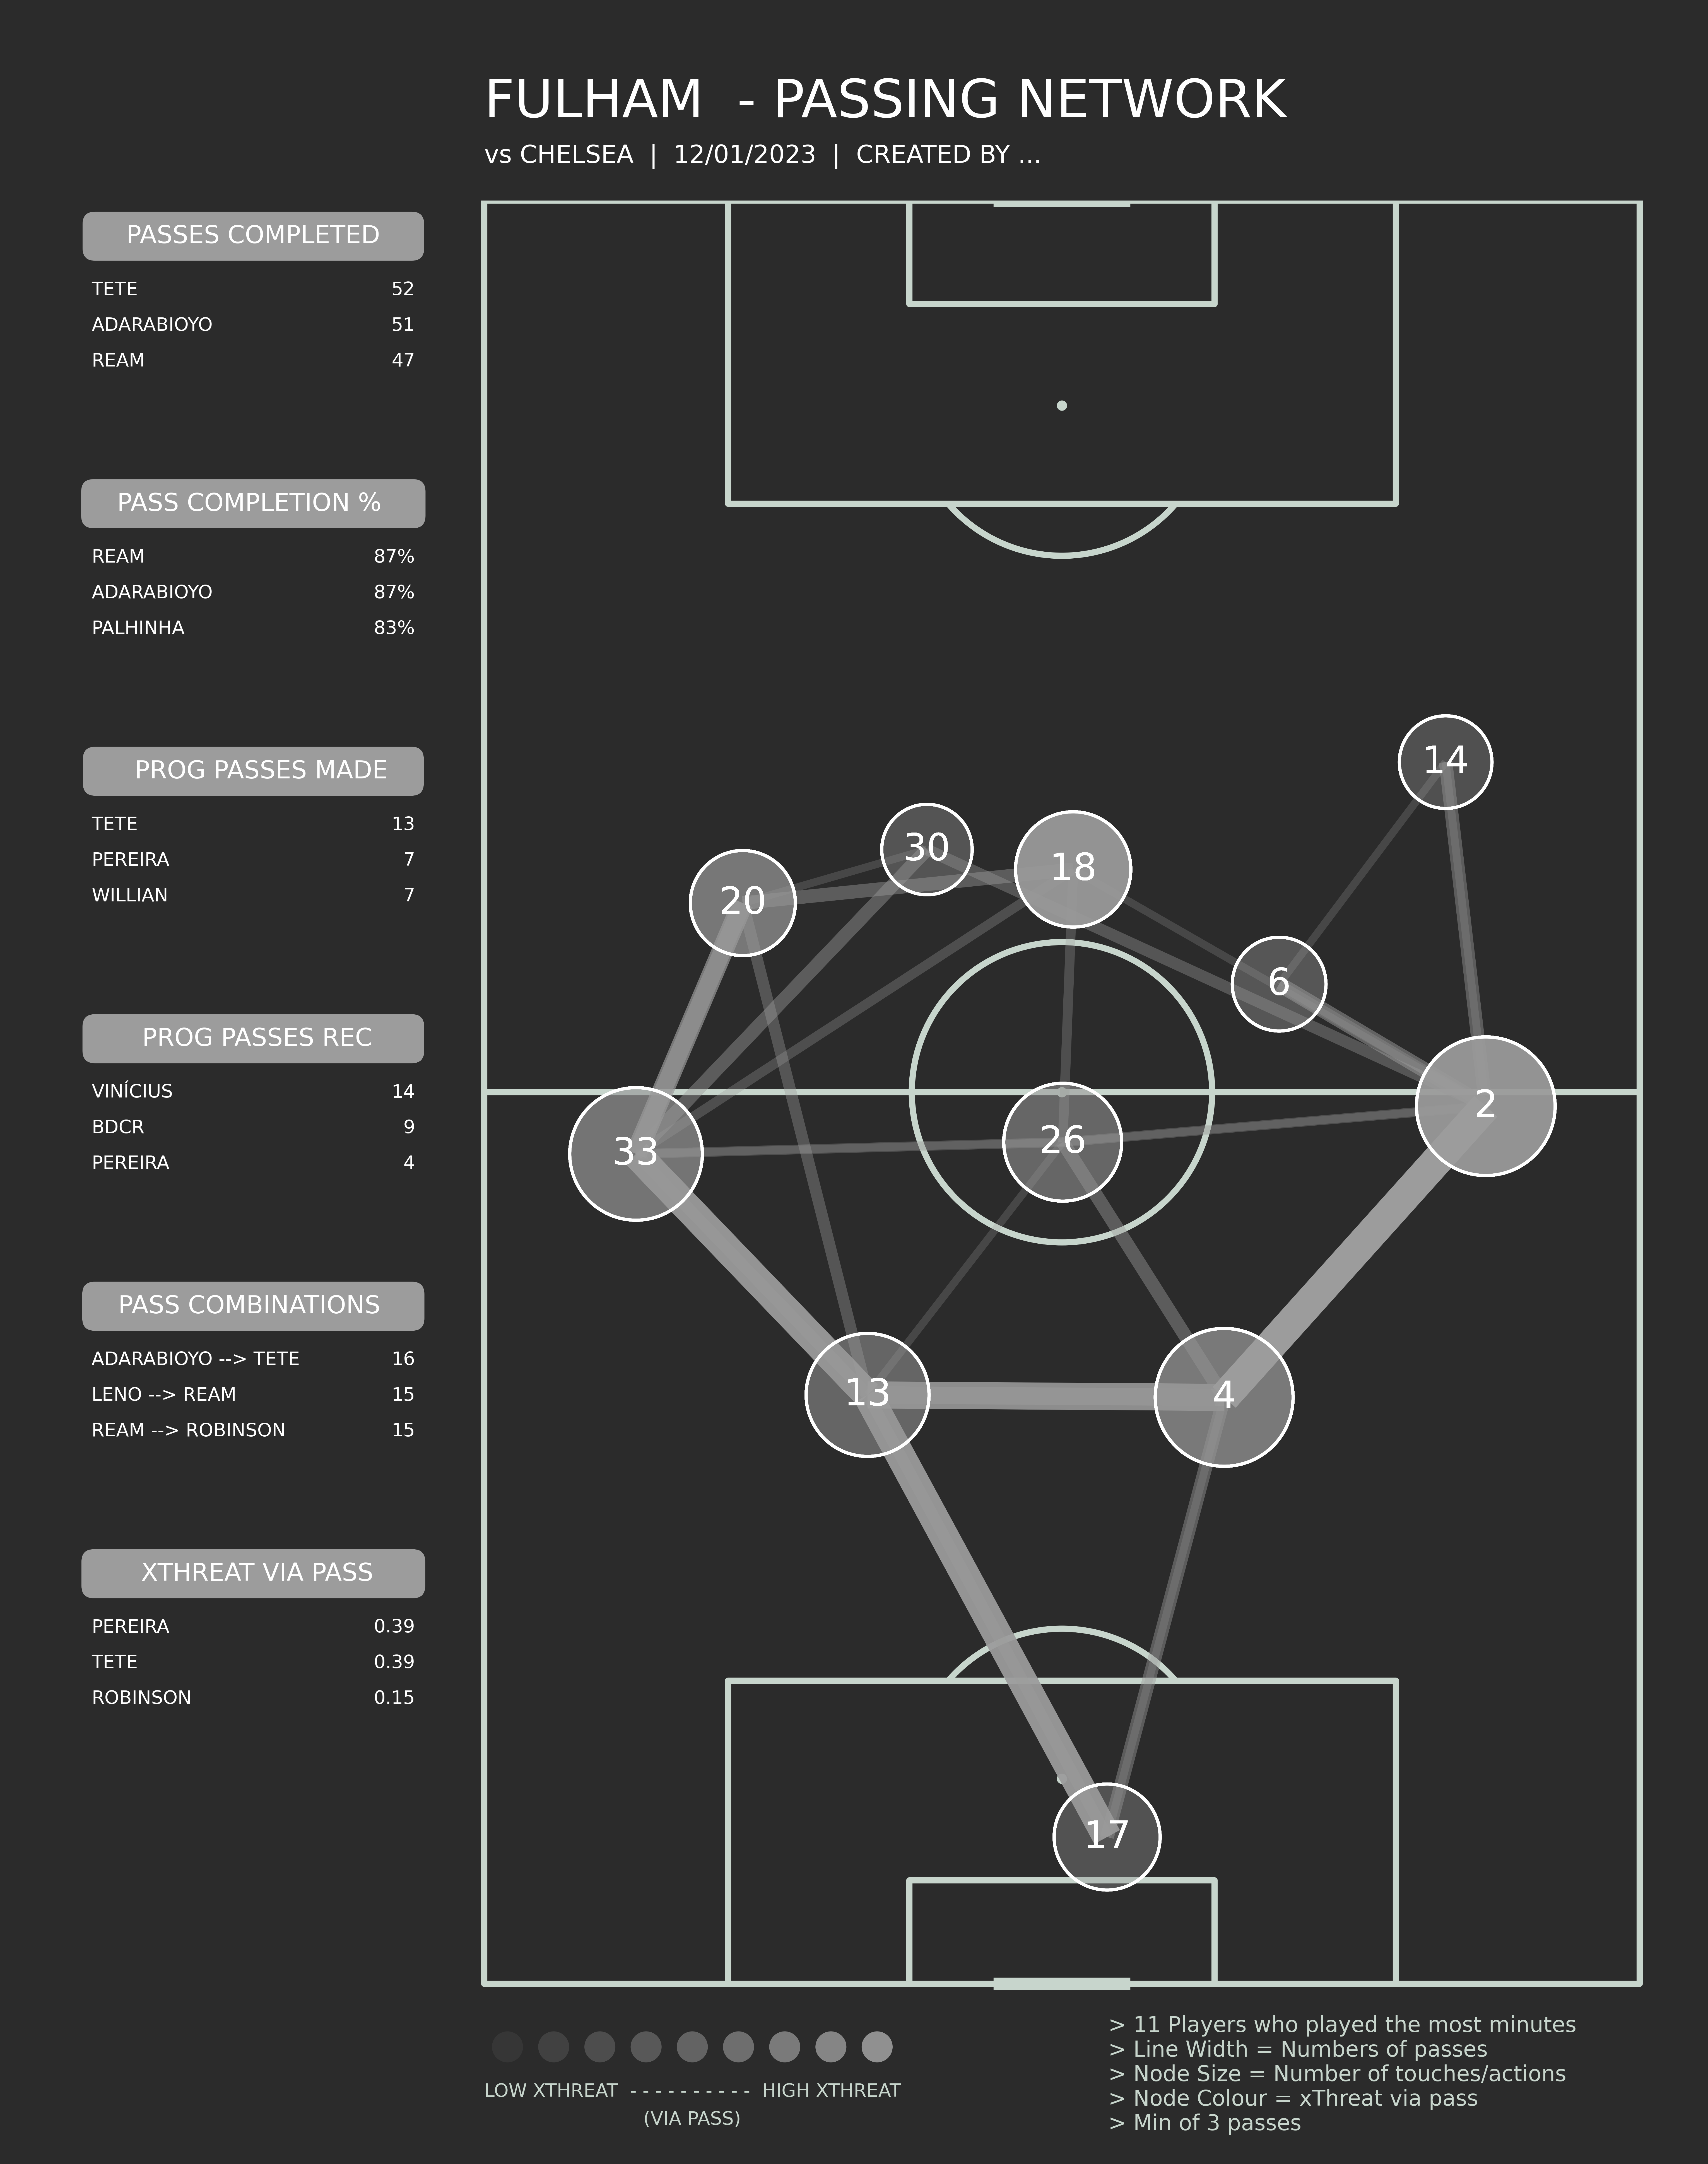

In [57]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 800

MIN_TRANSPARENCY = 0.
color = np.array(to_rgba(home_color))
color = np.tile(color, (len(passes_t1), 1))
c_transparency = passes_t1.passes / (passes_t1.passes.max())
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

MIN_TRANSPARENCY2 = 0.05
color2 = np.array(to_rgba(home_color))
color2 = np.tile(color2, (len(passes_t1), 1))
c_transparency2 = (passes_t1.xThreat + passes_t1.xThreat.min())/ ((passes_t1.xThreat.max() + abs(passes_t1.xThreat.min())))
c_transparency2 = (c_transparency2 + MIN_TRANSPARENCY2)/4
color2[:, 3] = c_transparency2


pitch = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc',pad_top=0, pad_left = 40)
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)

fig.set_facecolor("#2B2B2B")

# rectangle1 = plt.Rectangle((0, 0),110,100, color=home_color)
# plt.gca().add_patch(rectangle1, ax=axs['left'])

axs['pitch'].annotate(text='    Passes Completed    '.upper(), xytext=(120, 98), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)

y = 95
i = 0
for p1, cnt in comp_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1
axs['pitch'].annotate(text='   Pass Completion %    '.upper(), xytext=(120, 83), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 80
i = 0
for p1, cnt in pass_comp:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=str(cnt)+'%', 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1



axs['pitch'].annotate(text='     Prog Passes Made   '.upper(), xytext=(120, 68), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 65
i = 0
for p1, cnt in prog_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1

axs['pitch'].annotate(text='      Prog Passes Rec     '.upper(), xytext=(120, 53), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 50
i = 0
for p1, cnt in prog_received_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1


axs['pitch'].annotate(text='   Pass Combinations    '.upper(), xytext=(120, 38), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color,  edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 35
i = 0
for p1, p2, cnt in combos_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    p2 = p2.replace('-', ' ')
    p2 = p2.split(' ')
    if len(p2) > 2:
        name = "".join([x[0].upper() for x in p2])
        p2 = name
    elif len(p2) == 1:
        p2 = p2[0]
    else:
        p2 = p2[1]

    axs['pitch'].annotate(text=p1.upper() + ' --> ' + p2.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1

axs['pitch'].annotate(text='      xThreat via Pass     '.upper(), xytext=(120, 23), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)

y = 20
i = 0
for p1, cnt in xT_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=str(cnt), 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1


# pass_arrows = pitch.arrows(passes_t1.x_start-1, passes_t1.y_start-1,
#                          passes_t1.x_end-1, passes_t1.y_end-1, lw=passes_t1.width,
#                          color=color, zorder=1, ax=axs['pitch'], headlength=6, 
#                          headwidth=4, headaxislength=3)

pass_lines = pitch.lines(passes_t1.x_start, passes_t1.y_start,
                         passes_t1.x_end, passes_t1.y_end, lw=passes_t1.width,
                         color=color, zorder=1, ax=axs['pitch'])


pass_nodes = pitch.scatter(passes_t1.x_start, passes_t1.y_start, s=passes_t1.marker_size,
                           color=color2, edgecolors='white', linewidth=1, ax=axs['pitch'])

for index, row in passes_t1.iterrows():
    pitch.annotate(row.no, xy=(row.x_start, row.y_start), color='white', va='center',
                   ha='center', size=12, ax=axs['pitch'], fontname='Sans Serif')
    
    
axs['title'].text(0, 0.55, home_name.upper() + '  - Passing Network'.upper(), color='White',
                  va='center', ha='left', fontsize=17, fontname='Sans Serif')
axs['title'].text(0, 0.25, 'vs ' + away_name.upper() + '  |  ' + date_str.upper() + '  |  '  + 'CREATED BY ...' ,color='White',
                  va='center', ha='left', fontsize=8)
    

axs['endnote'].set_xlim(0, 1)
axs['endnote'].set_ylim(0, 1)

axs['endnote'].text(0.54, 0.6, '> 11 Players who played the most minutes \n> Line Width = Numbers of passes \n> Node Size = Number of touches/actions \n> Node Colour = xThreat via pass \n> Min of 3 passes' , color='#c7d5cc',
                    va='center', ha='left', fontsize=7, fontname = 'Sans Serif')


right = 0.04
for i in range(9):
    axs['endnote'].scatter(0.02 + right*i, 0.85, s=100,
                           color=home_color, edgecolors='None',
                           marker='o', alpha=(i/10)+0.1)

    
axs['endnote'].text(0.00, 0.45, 'Low xThreat  - - - - - - - - - -  High xThreat'.upper(), color='#c7d5cc',
                    va='center', ha='left', fontsize=6, fontname = 'Sans Serif') 
axs['endnote'].text(0.1375, 0.2, '(via pass)'.upper(), color='#c7d5cc',
                    va='center', ha='left', fontsize=6, fontname = 'Sans Serif')

fig.savefig('passNetwork_oneteam.png', dpi=300)


## Two Teams

In [58]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.colors
# mpl.rcParams['figure.dpi'] = 800

MIN_TRANSPARENCY = 0.
color = np.array(to_rgba(home_color))
color = np.tile(color, (len(passes_t1), 1))
c_transparency = passes_t1.passes / (passes_t1.passes.max())
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

MIN_TRANSPARENCY2 = 0.05
color2 = np.array(to_rgba(home_color))
color2 = np.tile(color2, (len(passes_t1), 1))
c_transparency2 = (passes_t1.xThreat + abs(passes_t1.xThreat.min()))/ ((passes_t1.xThreat.max() + abs(passes_t1.xThreat.min())))
c_transparency2 = (c_transparency2 + MIN_TRANSPARENCY2)/3
color2[:, 3] = c_transparency2

MIN_TRANSPARENCY3 = 0.0
color3 = np.array(to_rgba(away_color))
color3 = np.tile(color3, (len(passes_t2), 1))
c_transparency3 = passes_t2.passes / (passes_t2.passes.max())
c_transparency3 = (c_transparency3 * (1 - MIN_TRANSPARENCY3)) + MIN_TRANSPARENCY3
color3[:, 3] = c_transparency3

MIN_TRANSPARENCY4 = 0.05
color4 = np.array(to_rgba(away_color))
color4 = np.tile(color4, (len(passes_t2), 1))
c_transparency4 = (passes_t2.xThreat + abs(passes_t2.xThreat.min()))/ ((passes_t2.xThreat.max() + abs(passes_t2.xThreat.min())))
c_transparency4 = (c_transparency4 + MIN_TRANSPARENCY4)/3
color4[:, 3] = c_transparency4

FIGWIDTH, FIGHEIGHT = 14, 10
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
FIG_ASPECT = FIGWIDTH / FIGHEIGHT
fig = plt.figure(figsize=FIGSIZE)
# mpl.rcParams['figure.dpi'] = 800

norm=plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#2B2B2B",home_color])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#2B2B2B",away_color])



pitch1 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_left = 40,
                       line_zorder=2, pad_bottom=20, pad_right=5,   linewidth=0.6, pitch_length=5, pad_top=30)
pitch2 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_right = 40,
                       line_zorder=2,  pad_bottom=20, pad_left=5,  linewidth=0.6, pitch_length=5, pad_top=30)

fig.set_facecolor("#2B2B2B")

TITLE_HEIGHT = 0.1 # title axes are 10% of the figure height

#  width of pitch axes as percent of the figure width
TOP_WIDTH = 0.48
BOTTOM_WIDTH = 0.25

# calculate the horizontal space between axes (and figure sides) in percent of the figure width
TOP_SPACE = (1 - (TOP_WIDTH * 2)) / 2
BOTTOM_SPACE = (1 - (BOTTOM_WIDTH * 3)) / 2

# calculate the height of the pitch axes in percent of the figure height
height1 = (TOP_WIDTH / pitch1.ax_aspect * FIG_ASPECT)
height2 = (TOP_WIDTH / pitch2.ax_aspect * FIG_ASPECT)


# calculate pitch offsets from center / title locations
vertical_axes_space = (1 - (height1 + TITLE_HEIGHT + TITLE_HEIGHT)) / 5
bottom_offset = ((1 - height2) / 2) - vertical_axes_space
title1_bottom = 1 - vertical_axes_space - TITLE_HEIGHT
title2_bottom = 1 - (vertical_axes_space * 3) - (TITLE_HEIGHT * 2) - height1
top_offset = (1 - title1_bottom - title2_bottom - TITLE_HEIGHT) / 2



# top left
LEFT1 = TOP_SPACE
bottom1 = (1 - height1) / 2 - top_offset
ax1 = fig.add_axes((LEFT1, bottom1, TOP_WIDTH, height1))
pitch1.draw(ax=ax1)

# top right
left2 = (TOP_SPACE ) + (TOP_WIDTH)
bottom2 = (1 - height2) / 2 - top_offset
ax2 = fig.add_axes((left2, bottom2, TOP_WIDTH, height2))
pitch2.draw(ax=ax2)

ax_title2 = fig.add_axes((0, title1_bottom-0.05, 1, TITLE_HEIGHT-0.05))
ax_title2.axis('off')
ax_title2.text(left2 ,0.45,
               f'{home_name} {score} { away_name}'.upper(),
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,1.1,
               'Passing Network'.upper(),
               color='white', size=18, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,-0.15,
               f'{date_str}  |  CREATED BY ...',
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')


pitch1.annotate(text=home_name.upper(), 
                          xytext=(102, 100), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax1)

pitch2.annotate(text=away_name.upper(), 
                          xytext=(102, 0), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax2)

pitch1.annotate(text=' Passes Completed   '.upper(), xytext=(98, 120), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax1)

y = 95
i = 0
for p1, cnt in comp_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax1)
    
    i += 1
    
pitch1.annotate(text=' Pass Completion %  '.upper(), xytext=(83, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax1)
y = 80
i = 0
for p1, cnt in pass_comp:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax1)
    pitch1.annotate(text=str(cnt)+'%', 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax1)
    
    i += 1



pitch1.annotate(text='   Prog Passes Made '.upper(), xytext=(68, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax1)
y = 65
i = 0
for p1, cnt in prog_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax1)
    
    i += 1

pitch1.annotate(text='    Prog Passes Rec   '.upper(), xytext=(53, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax1)
y = 50
i = 0
for p1, cnt in prog_received_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1


pitch1.annotate(text=' Pass Combinations  '.upper(), xytext=(38, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)
y = 35
i = 0
for p1, p2, cnt in combos_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    p2 = p2.replace('-', ' ')
    p2 = p2.split(' ')
    if len(p2) > 2:
        name = "".join([x[0].upper() for x in p2])
        p2 = name
    elif len(p2) == 1:
        p2 = p2[0]
    else:
        p2 = p2[1]

    pitch1.annotate(text=p1.upper() + ' --> ' + p2.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1

pitch1.annotate(text='    xThreat via Pass   '.upper(), xytext=(23, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)

y = 20
i = 0
for p1, cnt in xT_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i,134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=str(cnt), 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1

pass_lines = pitch1.lines(passes_t1.x_start, passes_t1.y_start,
                          passes_t1.x_end, passes_t1.y_end, lw=passes_t1.width,
                          color=color, zorder=1, ax=ax1)


pass_nodes = pitch1.scatter(passes_t1.x_start, passes_t1.y_start, s=passes_t1.marker_size,
                           color=color2, edgecolors='white', linewidth=1, ax=ax1)

for index, row in passes_t1.iterrows():
    pitch1.annotate(row.no, xy=(row.x_start, row.y_start), color='white', va='center',
                     ha='center', size=10, ax=ax1, fontname='Sans Serif')
    
right = 4
for i in range(9):
    pitch1.scatter(-3, 99 - right*i, s=100,
                           color=home_color, edgecolors='None',
                           marker='o', alpha=(i/10)+0.1, ax=ax1)

pitch1.annotate('Low xThreat  - - - - - -  High xThreat'.upper(), xytext=(-6,100.5), xy=(20,40),
                color='#c7d5cc',
                va='center', ha='left', fontsize=6, fontname = 'Sans Serif', ax=ax1) 
pitch1.annotate('(via pass)'.upper(), xytext=(-8, 87.5), xy=(20,40),
                color='#c7d5cc',
                va='center', ha='left', fontsize=6, fontname = 'Sans Serif', ax=ax1) 


left = 4
for i in range(9):
    pitch2.scatter(-3, 33 - right*i, s=100,
                           color=away_color, edgecolors='None',
                           marker='o', alpha=(i/10)+0.1, ax=ax2)

pitch2.annotate('Low xThreat  - - - - - -  High xThreat'.upper(), xytext=(-6,34.5), xy=(20,40),
                color='#c7d5cc',
                va='center', ha='left', fontsize=6, fontname = 'Sans Serif', ax=ax2) 
pitch2.annotate('(via pass)'.upper(), xytext=(-8,21.5), xy=(20,40),
                color='#c7d5cc',
                va='center', ha='left', fontsize=6, fontname = 'Sans Serif', ax=ax2) 


pitch1.annotate(xytext=(-6, 51),xy = (20,40),
                text='> 11 Players who played the most minutes \n> Line Width = Numbers of passes \n> Node Size = Number of touches/actions \n> Node Colour = xThreat via pass \n> Min of 3 passes', 
                color='#c7d5cc',
                va='center', ha='left', fontsize=7, fontname = 'Sans Serif', ax=ax1)


# Away Team
pitch2.annotate(text='  Passes Completed  '.upper(), xytext=(98, -20), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax2)

y = 95
i = 0
for p1, cnt in comp_passes_list2:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax2)
    
    i += 1
    
pitch2.annotate(text=' Pass Completion %  '.upper(), xytext=(83, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax2)
y = 80
i = 0
for p1, cnt in pass_comp2:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax2)
    pitch2.annotate(text=str(cnt)+'%', 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax2)
    
    i += 1



pitch2.annotate(text='   Prog Passes Made '.upper(), xytext=(68.5, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax2)
y = 65
i = 0
for p1, cnt in prog_passes_list2:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax = ax2)
    
    i += 1

pitch2.annotate(text='    Prog Passes Rec   '.upper(), xytext=(53, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax = ax2)
y = 50
i = 0
for p1, cnt in prog_received_list2:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1


pitch2.annotate(text=' Pass Combinations  '.upper(), xytext=(38, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)
y = 35
i = 0
for p1, p2, cnt in combos_list2:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    p2 = p2.replace('-', ' ')
    p2 = p2.split(' ')
    if len(p2) > 2:
        name = "".join([x[0].upper() for x in p2])
        p2 = name
    elif len(p2) == 1:
        p2 = p2[0]
    else:
        p2 = p2[1]

    pitch2.annotate(text=p1.upper() + ' --> ' + p2.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1

pitch2.annotate(text='    xThreat via Pass   '.upper(), xytext=(23, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)

y = 20
i = 0
for p1, cnt in xT_list3:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=str(cnt), 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1

pass_lines2 = pitch2.lines(passes_t2.x_start, passes_t2.y_start,
                         passes_t2.x_end, passes_t2.y_end, lw=passes_t2.width,
                         color=color3, zorder=1, ax=ax2)


pass_nodes2 = pitch2.scatter(passes_t2.x_start, passes_t2.y_start, s=passes_t2.marker_size,
                           color=color4, edgecolors='white', linewidth=1, ax=ax2)

for index, row in passes_t2.iterrows():
    pitch2.annotate(row.no, xy=(row.x_start, row.y_start), color='white', va='center',
                   ha='center', size=10, ax=ax2, fontname='Sans Serif')

    
fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos2 = 9879
club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
newax2 = fig.add_axes([0.025, 0.85, 0.1, 0.1], anchor='NE', zorder=2)
newax2.imshow(club_icon2)
newax2.axis('off')

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos = 8455
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos:.0f}.png'))
newax = fig.add_axes([0.85, 0.85, 0.1, 0.1], anchor='NE', zorder=2)
newax.imshow(club_icon)
newax.axis('off')

    
fig.savefig('passNetwork_twoteam.png', dpi=300)

    